<a href="https://colab.research.google.com/github/caroheymes/Jedha_conversion_rate/blob/master/Jedha_conversion_rate_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

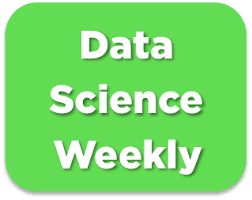

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [ ]:
!pip install matplotlib==3.4

In [1]:
!pip install sklearn -q

In [2]:
!pip install lightgbm -q
!pip install catboost -q
!pip install xgboost -q

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
os.chdir('/content/drive/MyDrive/08_28_conversion rate')

In [ ]:
!pip install missingpy -q

In [3]:
import pandas as pd
pd.set_option('display.width', 350)
import numpy as np
import warnings
warnings.filterwarnings("ignore") # to avoid deprecation warnings
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, confusion_matrix,  precision_score, recall_score


import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display
from IPython.display import HTML

# Read file with labels

In [6]:
data= pd.read_csv('/content/drive/MyDrive/08_28_conversion rate/conversion_data_train.csv')


In [7]:
data.describe()

age       new_user  total_pages_visited      converted
count  284580.000000  284580.000000        284580.000000  284580.000000
mean       30.564203       0.685452             4.873252       0.032258
std         8.266789       0.464336             3.341995       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000

In [8]:
data.isna().sum().mul(100)/data.shape[0]

country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [ ]:
# Conclusion : No empty values

# Explore dataset

The dataset is quite big : you must create a sample of the dataset before making any visualizations !

In [9]:
#Geographic coverage
data.country.value_counts(normalize=True).mul(100).round()

US         56.0
China      24.0
UK         15.0
Germany     4.0
Name: country, dtype: float64

In [10]:
#Conclusion :  Nationalities are a criteria for stratifying our dataset for visualizations

In [11]:
#Proportion of customers
data.converted.value_counts(normalize=True)

0    0.967742
1    0.032258
Name: converted, dtype: float64

In [12]:
#Conclusion : The dataset is almost entirely made up of prospects. This feature will not be taken for stratification.

In [13]:
#Building our stratified sample for visualisation

#Sampling on locations : 
US = data[data.country == 'US'].sample(5600)
CN = data[data.country == 'China'].sample(2400)
UK = data[data.country == 'UK'].sample(1500)
DE = data[data.country == 'Germany'].sample(400)

data_sample = pd.concat([US, CN, UK, DE], axis=0)


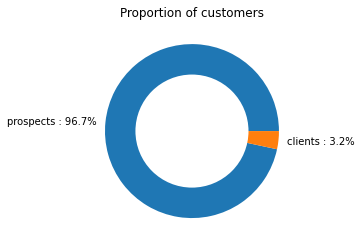

In [14]:
#Proportion of customers
title = 'Proportion of customers'


ax = plt.pie(data_sample.converted.value_counts(normalize=True), labels = ['prospects : 96.7%', 'clients : 3.2%'])
centre_circle = plt.Circle((0,0),0.65,fc='white') 
plt.title(title)
fig = plt.gcf() 
fig.gca().add_artist(centre_circle);

In [ ]:
# Conclusion : most of users do not convert

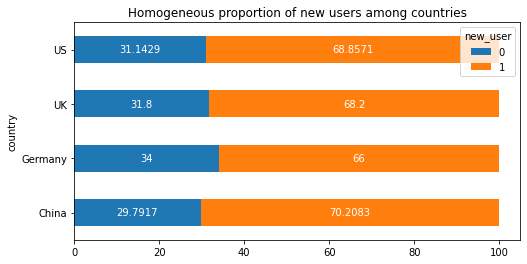

In [15]:
# Is the proportion of the new customers homogeneous among the countries?
ax = data_sample.groupby(['country'])['new_user'].value_counts(normalize=True).mul(100).unstack().plot(kind='barh', stacked=True,figsize=(8,4))
for c in ax.containers:
    ax.bar_label(c, label_type='center', color="white")
plt.title('Homogeneous proportion of new users among countries');

In [ ]:
#Conclusion : in Germany "new users" convert more

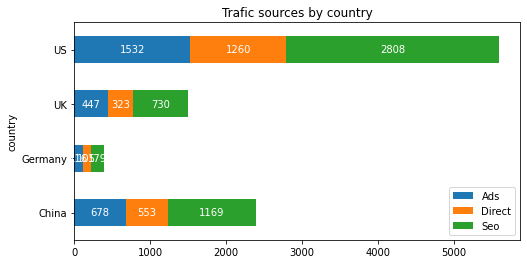

In [16]:
#Which sources drive the more trafic ?
ax = data_sample.groupby(['country'])['source'].value_counts().unstack().plot(kind = 'barh', stacked=True,figsize=(8,4))
plt.title('Trafic sources by country')
plt.legend(loc = 'best')
for c in ax.containers:
    ax.bar_label(c, label_type='center', color="white");

In [ ]:
#Conclusion : SEO represents half of the trafic sources

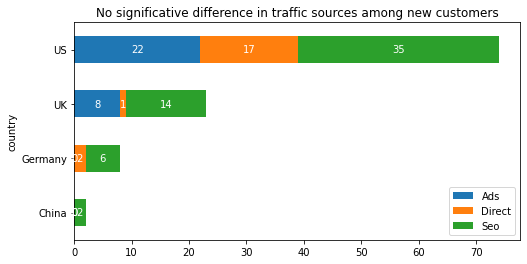

In [17]:
# Is there any difference among new user who are converted ?
ax = data_sample[(data_sample.new_user == 1) & (data_sample.converted == 1)].groupby(['country'])['source'].value_counts().unstack().plot(kind = 'barh', stacked=True,figsize=(8,4))
plt.title('No significative difference in traffic sources among new customers')
plt.legend(loc = 'best')
for c in ax.containers:
    ax.bar_label(c, label_type='center', color="white");

In [ ]:
# Conclusion: awareness is proportionally lower in the UK and China

Plot pairwise relationships in the dataset

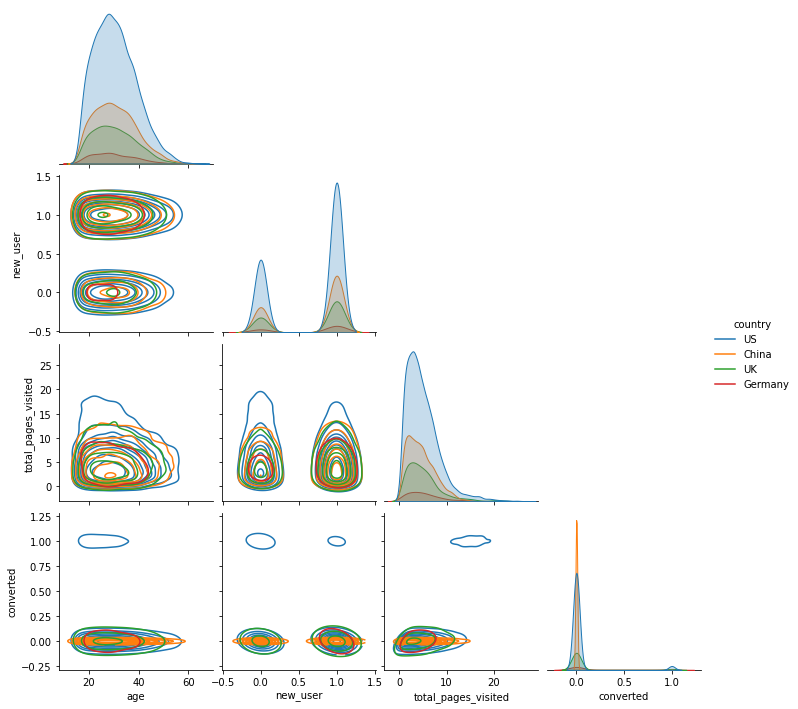

In [45]:
sns.pairplot(data_sample,corner=True,kind="kde", hue='country');

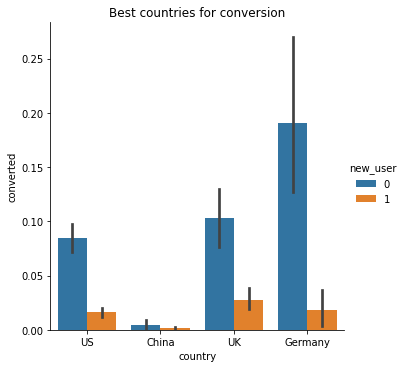

In [46]:
# which countries have the highest /lowest conversion rates?
sns.catplot(x='country',y='converted', data=data_sample,kind = 'bar', hue='new_user')
plt.title('Best countries for conversion');

In [ ]:
# Conclusion : German users convert the most but only 4% of customers come from Germany !

Detection of correlations

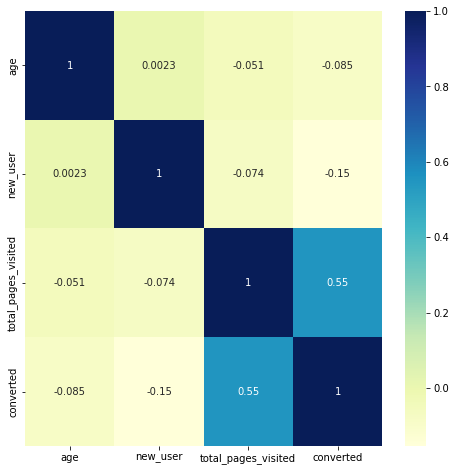

In [49]:
# Detection of highly correlated features
# Plotting a matrix correlation of features
corr = data_sample.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap='YlGnBu');

In [ ]:
# Conclusion : There appears to be a significant correlation between page views and conversion

In [50]:
#Let's check most correlated features :
correlations = corr.unstack().reset_index()
correlations = correlations.rename(columns=dict(zip(correlations.columns, ['feature1', 'feature2', 'coeff'])))
correlations['coeff'] = correlations['coeff'].apply(lambda x : abs(x))

#Filtering features with a high correlation : 
correlations[(correlations.coeff !=1) &  (correlations.coeff > 0.8)].drop_duplicates(subset=['coeff'])

Empty DataFrame
Columns: [feature1, feature2, coeff]
Index: []

In [ ]:
# Conclution : There is no colinearity between the features

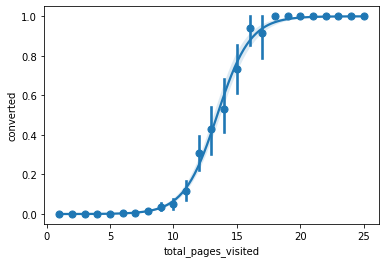

In [19]:
#average number of page to conversion regardless of country
ax = sns.regplot(x="total_pages_visited", y="converted", data=data_sample,
                 x_estimator=np.mean, logistic=True)

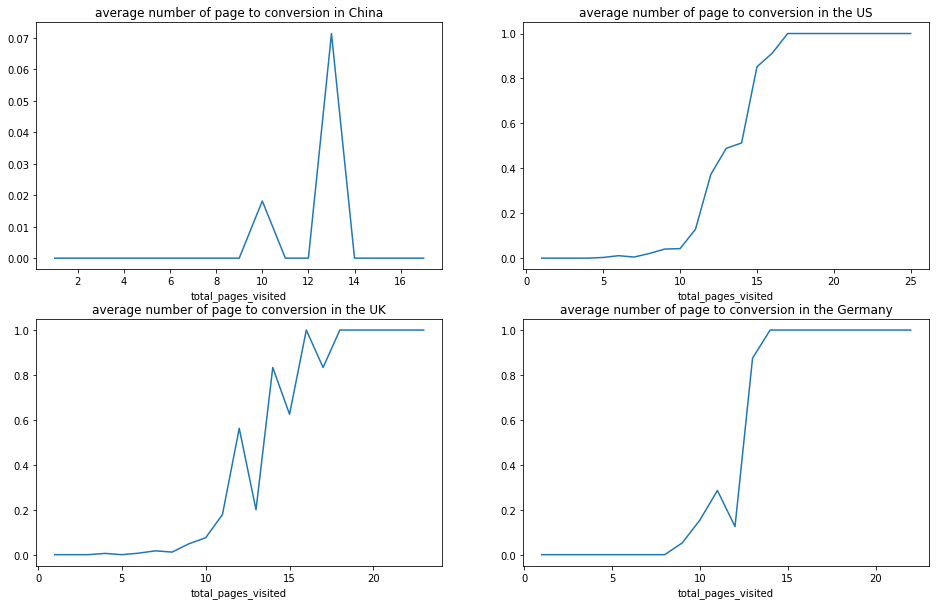

In [18]:
# There a relationship between the page views and conversion: Are there disparities among countries?
fig = plt.figure(figsize = (16,10))
plt.subplot(2, 2, 1)
ax1 = data_sample[data_sample.country == 'China'].groupby(['total_pages_visited'])['converted'].mean().plot();
plt.title("average number of page to conversion in China")

plt.subplot(2, 2, 2)
ax1 = data_sample[data_sample.country == 'US'].groupby(['total_pages_visited'])['converted'].mean().plot();
plt.title("average number of page to conversion in the US")

plt.subplot(2, 2, 3)
ax1 = data_sample[data_sample.country == 'UK'].groupby(['total_pages_visited'])['converted'].mean().plot();
plt.title("average number of page to conversion in the UK")

plt.subplot(2, 2, 4)
ax1 = data_sample[data.country == 'Germany'].groupby(['total_pages_visited'])['converted'].mean().plot();
plt.title("average number of page to conversion in the Germany");



 **Conclusion** 
There is a relationship between the pages views and conversion : the more pages you see, the more content you read, the more likely you are to find something of interest and buy it !

# Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [46]:
#Code factorization
from sklearn.metrics import precision_score,accuracy_score, recall_score,f1_score

def get_scores(model,X_train, Y_train):
  #Fit the model
  model.fit(X_train, Y_train)
  Y_train_pred  = model.predict(X_train)
  Y_test_pred   = model.predict(X_test)

  #Get the metrics
  accuracy      = accuracy_score(Y_test, Y_test_pred)
  precision     = precision_score(Y_test, Y_test_pred) #proportion of predicted A that are actually A :  TP / (TP + FP)
  recall        = recall_score(Y_test, Y_test_pred)   # A detected as A by the model divided by the total number of A in whole dataset TP / (TP + FN)
  f1            = f1_score(Y_test, Y_test_pred)       #2 * precision * recall / (precision_score + recall)

  scores = []
  scores.append({   'model'     : model,
                    'accuracy'  : accuracy,
                    'precision' : precision,
                    'recall'    : recall,
                    'f1score'   :  f1
                    })
  all_scores = pd.DataFrame(data= scores)

  return all_scores

In [214]:
data = pd.read_csv('/content/drive/MyDrive/08_28_conversion rate/conversion_data_train.csv')
test = pd.read_csv('/content/drive/MyDrive/08_28_conversion rate/conversion_data_test.csv')


In [219]:
#Basic pre-processing for univariate prediction

X     = data[['total_pages_visited']]
Y     = data[['converted']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#Normalize the data
mu = X_train.total_pages_visited.mean()
sigma = X_train.total_pages_visited.std()

X_train['total_pages_visited'] = X_train.total_pages_visited.apply(lambda x: (x - mu) / sigma) 
X_test['total_pages_visited'] = X_test.total_pages_visited.apply(lambda x: (x - mu) / sigma)


In [255]:
# Test other models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

sgd   = sklearn.linear_model.SGDClassifier()
knn   = KNeighborsClassifier()
svc   = SVC()
dt    = DecisionTreeClassifier()

test = pd.DataFrame()
for model in [sgd,knn,svc, dt ] : 
  print('starting...')
  print(model)
  temp = get_scores(model,X_train, Y_train)
  test = pd.concat([test, temp], axis=0)
test


starting...
SGDClassifier()
starting...
KNeighborsClassifier()
starting...
SVC()
starting...
DecisionTreeClassifier()


model  accuracy  precision    recall   f1score
0           SGDClassifier()  0.981921   0.902037  0.500538  0.643821
0    KNeighborsClassifier()  0.981657   0.722162  0.712056  0.717073
0                     SVC()  0.983115   0.829054  0.608181  0.701645
0  DecisionTreeClassifier()  0.983115   0.829054  0.608181  0.701645

In [256]:
# testing other classification performance
sgd   = sklearn.linear_model.SGDClassifier()
knn   = KNeighborsClassifier()
svc   = SVC()
dt    = DecisionTreeClassifier()
lr    = LogisticRegression()
rf    = RandomForestClassifier()
xgb   = GradientBoostingClassifier()
sgdc  = SGDClassifier()
gbm   = XGBClassifier()
et    = ExtraTreesClassifier()
ada   = AdaBoostClassifier()
cb    = CatBoostClassifier()

test2 = pd.DataFrame()
for model in [lr, sgd,knn,svc, dt, rf, xgb, sgdc, gbm, et, ada, cb ] : 
  print('starting...')
  print(model)
  temp = get_scores(model,X_train, Y_train)
  test2 = pd.concat([test2, temp], axis=0)
test2



starting...
LogisticRegression()
starting...
SGDClassifier()
starting...
KNeighborsClassifier()
starting...
SVC()
starting...
DecisionTreeClassifier()
starting...
RandomForestClassifier()
starting...
GradientBoostingClassifier()
starting...
SGDClassifier()
starting...
XGBClassifier()
starting...
ExtraTreesClassifier()
starting...
AdaBoostClassifier()
starting...
Learning rate set to 0.104592
0:	learn: 0.4380438	total: 115ms	remaining: 1m 54s
1:	learn: 0.2810141	total: 158ms	remaining: 1m 19s
2:	learn: 0.1936212	total: 198ms	remaining: 1m 5s
3:	learn: 0.1436652	total: 238ms	remaining: 59.1s
4:	learn: 0.1132919	total: 278ms	remaining: 55.4s
5:	learn: 0.0965931	total: 325ms	remaining: 53.8s
6:	learn: 0.0830568	total: 364ms	remaining: 51.7s
7:	learn: 0.0749342	total: 400ms	remaining: 49.6s
8:	learn: 0.0682061	total: 439ms	remaining: 48.3s
9:	learn: 0.0639560	total: 480ms	remaining: 47.6s
10:	learn: 0.0607723	total: 534ms	remaining: 48s
11:	learn: 0.0584111	total: 578ms	remaining: 47.5s
12:

model  ...   f1score
0                               LogisticRegression()  ...  0.701645
0                                    SGDClassifier()  ...  0.701645
0                             KNeighborsClassifier()  ...  0.717073
0                                              SVC()  ...  0.701645
0                           DecisionTreeClassifier()  ...  0.701645
0  (DecisionTreeClassifier(max_features='auto', r...  ...  0.701645
0  ([DecisionTreeRegressor(criterion='friedman_ms...  ...  0.701645
0                                    SGDClassifier()  ...  0.701645
0                                    XGBClassifier()  ...  0.701645
0  (ExtraTreeClassifier(random_state=238809704), ...  ...  0.701645
0  (DecisionTreeClassifier(max_depth=1, random_st...  ...  0.701645
0  <catboost.core.CatBoostClassifier object at 0x...  ...  0.701645

[12 rows x 5 columns]

In [ ]:
#Conclusion : All thoses models have very similar performances. For further analysis we'll go on with LogisticRegression

Testing over and under sampling technique

In [158]:
# Under-sampling

from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
print('Original dataset shape %s' % Counter(Y_train.converted))

rUs = RandomUnderSampler(random_state=42)
X_ru, y_ru = rUs.fit_resample(X_train, Y_train)
print('Resampled dataset shape %s' % Counter(y_ro.converted))

# Model training
lr.fit(X_ru, y_ru)

# Classification report
Y_test_pred = lr.predict(X_test)
print(classification_report_imbalanced(Y_test, Y_test_pred))

Original dataset shape Counter({0: 220342, 1: 7322})
Resampled dataset shape Counter({0: 220342, 1: 220342})
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.94      0.91      0.97      0.92      0.86     55058
          1       0.34      0.91      0.94      0.50      0.92      0.85      1858

avg / total       0.98      0.94      0.91      0.95      0.92      0.86     56916



In [159]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
X     = data[['total_pages_visited']]
Y     = data[['converted']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# #Normalize the data
mu = X_train.total_pages_visited.mean()
sigma = X_train.total_pages_visited.std()

X_train['total_pages_visited'] = X_train.total_pages_visited.apply(lambda x: (x - mu) / sigma) 
X_test['total_pages_visited'] = X_test.total_pages_visited.apply(lambda x: (x - mu) / sigma)


print('Original dataset shape %s' % Counter(Y_train.converted))

# Over-sampling
rOs = RandomOverSampler(random_state=42)
X_ro, y_ro = rOs.fit_resample(X_train, Y_train)

print('Resampled dataset shape %s' % Counter(y_ro.converted))


# Model training
lr = LogisticRegression()
lr.fit(X_ro, y_ro)

# Classification report
Y_test_pred = lr.predict(X_test)
print(classification_report_imbalanced(Y_test, Y_test_pred))

Original dataset shape Counter({0: 220342, 1: 7322})
Resampled dataset shape Counter({0: 220342, 1: 220342})
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.94      0.91      0.97      0.92      0.86     55058
          1       0.34      0.91      0.94      0.50      0.92      0.85      1858

avg / total       0.98      0.94      0.91      0.95      0.92      0.86     56916



Testing grid search cross validation

In [161]:
#Grid search cross validation
grid={
    "C":np.logspace(-1,1 , 5), 
    "penalty":["l1","l2"],        # l1 stands for  the sum of the absolute values of the coefficients, aka the Manhattan distance
                                  # l2 stands for the sum of the squared of the coefficients, aka the square of the Euclidian distance, multiplied by ½.
    'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'warm_start' : [True, False]
    }
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train,Y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear', 'warm_start': True}
accuracy : 0.9829178091622733


In [72]:
new_model = LogisticRegression(C= 0.005994842503189421, penalty= 'l1', solver= 'liblinear', warm_start= True)
df = get_scores(new_model,X_train, Y_train)
df

model  ...   f1score
0  LogisticRegression(C=0.005994842503189421, pen...  ...  0.701645

[1 rows x 5 columns]

In [ ]:
#Conclusion : hyper parameters search led to no improvement ! Perhaps did I chose the wrong parameter initializers.
# Whatever, ... an over or under sampling may help with same proportion of converted / non converted (strong increase in the f1 score)

# Train best classifier with resampling on all data to make predictions


In [258]:
train = pd.read_csv('/content/drive/MyDrive/08_28_conversion rate/conversion_data_train.csv')
train['converted'] = train.converted.astype(int)
test = pd.read_csv('/content/drive/MyDrive/08_28_conversion rate/conversion_data_test.csv')


In [263]:
#Trial with oversampling 

X_train = train[['total_pages_visited']]
print('initial ', X_train.shape)
Y_train = train[['converted']]
print('initial ', Y_train.shape)
X_test =  test[['total_pages_visited']]

#Normalize the data
mu = X_train.total_pages_visited.mean()
sigma = X_train.total_pages_visited.std()

X_train['total_pages_visited'] = X_train.total_pages_visited.apply(lambda x: (x - mu) / sigma) 
X_test['total_pages_visited'] = X_test.total_pages_visited.apply(lambda x: (x - mu) / sigma)


#Instantiate logistic regression model
model    = LogisticRegression()

# Over-sampling
rOs = RandomOverSampler(random_state=42)
# X_train, Y_Train =  rOs.fit_resample(X_train, Y_train)
X_ro, y_ro = rOs.fit_resample(X_train, Y_train)
print(X_ro.shape)
print(y_ro.shape)

#Fit the model

model.fit(X_ro, y_ro)
Y_train_pred  = model.predict(X_ro)
Y_test_pred   = model.predict(X_test)


# #Get the metrics
accuracy_train  = accuracy_score(Y_train, Y_train_pred)
precision_train = precision_score(Y_train, Y_train_pred)
recall_train = recall_score(Y_train, Y_train_pred)
f1_score_train = f1_score(Y_train, Y_train_pred)

metrics = []
metrics.append({   'model'     : model,
                    'accuracy_train'  : accuracy_train,
                    'precision_train' : precision_train,
                    'recall_train'    : recall_train,
                    'f1score_train'   :  f1_score_train
                    })
metrics = pd.DataFrame(data= metrics)
metrics




initial  (18360, 1)
initial  (18360, 1)
(18360, 1)
(18360, 1)


model  accuracy_train  ...  recall_train  f1score_train
0  LogisticRegression()        0.920261  ...      0.897821       0.918431

[1 rows x 5 columns]

Custom stratification, with same proportion of customers and non customers for benchmark

In [257]:
Counter(train.converted)

Counter({0: 275400, 1: 9180})

In [261]:
#Custom resampling the train cf Counter({0: 275400, 1: 9180})
train = pd.concat([train[train.converted == 1], train[train.converted == 0].sample(train[train.converted == 1].shape[0])], axis=0)

X_train = train[['total_pages_visited']]
print('initial ', X_train.shape)
Y_train = train[['converted']]
print('initial ', Y_train.shape)
X_test =  test[['total_pages_visited']]

#Normalize the data
mu = X_train.total_pages_visited.mean()
sigma = X_train.total_pages_visited.std()

X_train['total_pages_visited'] = X_train.total_pages_visited.apply(lambda x: (x - mu) / sigma) 
X_test['total_pages_visited'] = X_test.total_pages_visited.apply(lambda x: (x - mu) / sigma)


#Instantiate logistic regression model
model    = LogisticRegression()

#Fit the model
model.fit(X_train, Y_train)

Y_train_pred  = model.predict(X_train)
Y_test_pred   = model.predict(X_test)


# #Get the metrics
accuracy_train  = accuracy_score(Y_train, Y_train_pred)
precision_train = precision_score(Y_train, Y_train_pred)
recall_train = recall_score(Y_train, Y_train_pred)
f1_score_train = f1_score(Y_train, Y_train_pred)



metrics = []
metrics.append({   'model'     : model,
                    'accuracy_train'  : accuracy_train,
                    'precision_train' : precision_train,
                    'recall_train'    : recall_train,
                    'f1score_train'   :  f1_score_train
                    })
metrics = pd.DataFrame(data= metrics)
metrics

initial  (18360, 1)
initial  (18360, 1)


model  accuracy_train  ...  recall_train  f1score_train
0  LogisticRegression()        0.920261  ...      0.897821       0.918431

[1 rows x 5 columns]

In [ ]:
#Conclusion : these 2 models have similar performance

In [206]:
#Predictions
preds = pd.DataFrame(model.predict(X_test))
preds.to_csv('preds.csv')
preds

0
0      1
1      0
2      0
3      0
4      0
...   ..
31615  0
31616  0
31617  0
31618  1
31619  0

[31620 rows x 1 columns]

# Analysing the importance of other features to find some lever action to improve conversion rate

we just trained a model with only one feature : the page views. Which other levers may be usefull ?

In [296]:
data = pd.read_csv('/content/drive/MyDrive/08_28_conversion rate/conversion_data_train.csv')
target = 'converted'

X = data.loc[:, data.columns != target]
Y = data.loc[:,target] 

Y = Y.apply(lambda x: float(x[1:]) if type(x)==str else x)

#Split the data into a train set and test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=X.country)#we stratify by country



# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()
print("...Numpy conversion to arrays Done !")


Convert pandas DataFrames to numpy arrays...
...Numpy conversion to arrays Done !


In [297]:
#Numeric / categorical features and indices
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
        numeric_indices.append(idx)
    else :
        categorical_features.append(i)
        categorical_indices.append(idx)

    idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['age', 'new_user', 'total_pages_visited']  at positions  [1, 2, 4]
Found categorical features  ['country', 'source']  at positions  [0, 3]


In [298]:
from missingpy import KNNImputer
imputer = KNNImputer()

numeric_transformer = Pipeline(steps=[
    ('imputer',KNNImputer()),
    ('scaler',StandardScaler()) 
])
#StandardScaler()
# Create pipeline for categorical features

categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('preprocessings on train set...Done.')


# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('preprocessings on test set...Done.')

Performing preprocessings on train set...
preprocessings on train set...Done.
Performing preprocessings on test set...
preprocessings on test set...Done.


In [299]:
#Model fitting
model = LogisticRegression()
get_scores(model,X_train, Y_train)

model  accuracy  precision    recall   f1score
0  LogisticRegression()  0.986014   0.857943  0.673997  0.754926

In [300]:
preprocessed_features = []
preprocessed_features = numeric_features
cat_features_preprocessed = preprocessor.transformers_[1][1][1].get_feature_names()

preprocessed_features +=cat_features_preprocessed.tolist()
preprocessed_features

['age',
 'new_user',
 'total_pages_visited',
 'x0_Germany',
 'x0_UK',
 'x0_US',
 'x1_Direct',
 'x1_Seo']

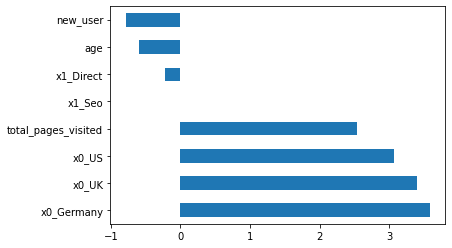

In [303]:
importance = model.coef_[0]
feat_importances = pd.Series(importance, index=preprocessed_features)
feat_importances.sort_values(ascending=False).plot(kind='barh');

# Better features explanation with Shapash

In [ ]:
!pip install shapash

Shapash is an overlay package for libraries dedicated to the interpretability of models. It uses Shap or Lime backend to compute contributions. Shapash builds on the different steps necessary to build a machine learning model to make the results understandable

In [8]:
!pip install category_encoders -q

In [34]:
from shapash.explainer.smart_explainer import SmartExplainer
from category_encoders import OrdinalEncoder

data = pd.read_csv('/content/drive/MyDrive/08_28_conversion rate/conversion_data_train.csv')


target = 'converted'

X = data.loc[:, data.columns != target]
Y = data.loc[:,target] 


Y = Y.apply(lambda x: float(x[1:]) if type(x)==str else x)


categorical_features = [col for col in X.columns if X[col].dtype == 'object']
encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X)

X=encoder.transform(X)


#Split the data into a train set and test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

model           = LogisticRegression()
model.fit(X_train, Y_train)

response_dict   = {0: 'prospect', 1:'customer'}
xpl             = SmartExplainer(label_dict=response_dict)

Y_pred = pd.DataFrame(model.fit(X_train, Y_train).predict(X_test),columns=['pred'],index=X_test.index)

xpl.compile(
    x       = X_test,
    model   = model.fit(X_train, Y_train),
    y_pred  = Y_pred,
    preprocessing=encoder
            )

Backend: Shap LinearExplainer


In [39]:
xpl.plot.features_importance(label='customer')

In [40]:
#Conclusion : Acquisition  is key for conversion. Marketing budget should focus on awareness and consideration stage

In [48]:
xpl.plot.contribution_plot(col='age', label = 'customer', max_points=2000)

In [ ]:
#Conclusion : boomers don't buy

In [45]:
xpl.plot.contribution_plot('source', label='customer')

In [46]:
# Conclusion : It is imperative to invest in quality organic content to be better referenced by Google (90% of traffic).
# Better content (in quality and quantity) is key to be well positionned in the SERP.
# Content matching long train queries on Google can help to be well-positionned in the SERP.
# Prospects find the products they need, and spend more time on the website.